# Import Libraries

In [1]:
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from math import sqrt
from pandas import concat
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

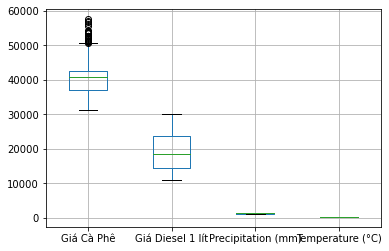

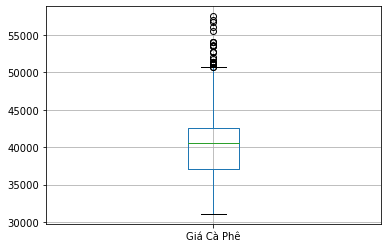

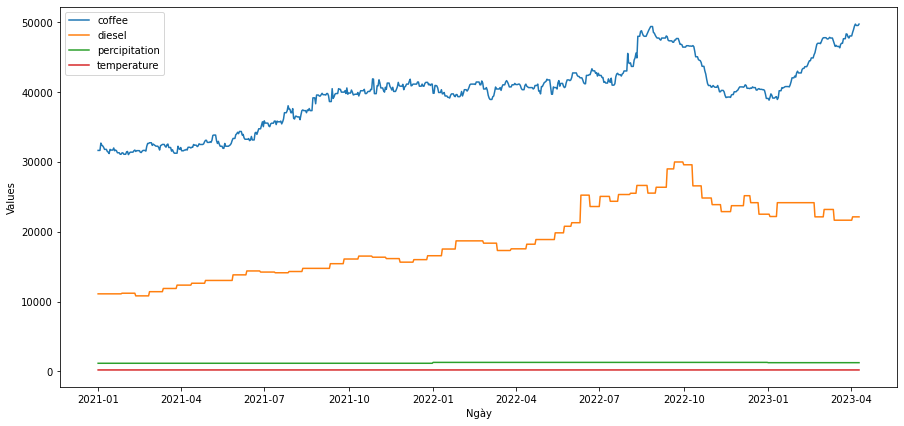

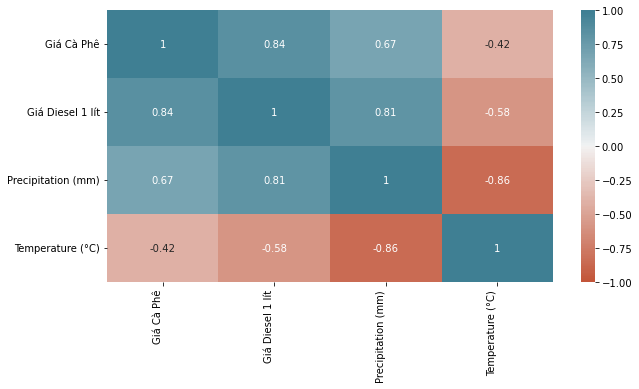

Stored 'data' (DataFrame)


In [2]:
%run Data.ipynb

# ---------- Retrieve Data -----------

In [3]:
%store -r data
data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm),Temperature (°C)
0,2021-01-01,31667.5,11120.0,1174.199994,217.0
1,2021-01-02,31667.5,11120.0,1174.199994,217.0
2,2021-01-03,31667.5,11120.0,1174.199994,217.0
3,2021-01-04,32717.0,11120.0,1174.199994,217.0
4,2021-01-05,32417.0,11120.0,1174.199994,217.0
...,...,...,...,...,...
825,2023-04-06,49766.5,22150.0,1259.800013,218.0
826,2023-04-07,49566.5,22150.0,1259.800013,218.0
827,2023-04-08,49566.5,22150.0,1259.800013,218.0
828,2023-04-09,49566.5,22150.0,1259.800013,218.0


In [4]:
# take coffee price only
data.drop(data.columns[[-1, -2]], axis=1, inplace=True)

In [5]:
data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít
0,2021-01-01,31667.5,11120.0
1,2021-01-02,31667.5,11120.0
2,2021-01-03,31667.5,11120.0
3,2021-01-04,32717.0,11120.0
4,2021-01-05,32417.0,11120.0
...,...,...,...
825,2023-04-06,49766.5,22150.0
826,2023-04-07,49566.5,22150.0
827,2023-04-08,49566.5,22150.0
828,2023-04-09,49566.5,22150.0


# --------- Normalization ----------

In [6]:
# drop date column
data.drop(data.columns[[0]], axis=1, inplace=True)

In [7]:
# set number of days
look_back = 60
predict_ahead = 30

# frame as supervised learning
reframed = series_to_supervised(data.values, look_back, predict_ahead)

In [8]:
# calculate total column to keep
data_column = len(data.columns)
keep_column = look_back * data_column
var_index = (look_back * data_column) + ((predict_ahead - 1) * data_column)

# drop unnecessary columns
reframed = reframed.drop(reframed.iloc[:, keep_column:var_index], axis = 1)
# index_drop = (data_column - 1 ) * -1
# reframed = reframed.drop(columns=reframed.columns[index_drop:], axis = 1)
# dataset = reframed

In [9]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(reframed)
scaled.shape

(740, 122)

In [10]:
scaled

array([[0.03272569, 0.01511992, 0.03272569, ..., 0.        , 0.01101959,
        0.        ],
       [0.03272569, 0.01511992, 0.03272569, ..., 0.        , 0.02559299,
        0.        ],
       [0.03272569, 0.01511992, 0.08992071, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.44957628, 0.59280501, 0.45230115, ..., 0.63401507, 0.98898041,
        0.55442177],
       [0.45230115, 0.59280501, 0.43050219, ..., 0.63401507, 0.98898041,
        0.55442177],
       [0.43050219, 0.69603754, 0.44412654, ..., 0.63401507, 1.        ,
        0.55442177]])

# ---------- Split data ----------

In [11]:
dataset = scaled

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

592 148


In [12]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(592, 1, 121) (592,) (148, 1, 121) (148,)


In [13]:
train.shape

(592, 122)

In [14]:
train = train.flatten()

# ---------- SARIMA ----------

In [18]:
from tqdm import tqdm  # Import tqdm for the progress bar
import pmdarima as pm

# Define a range of candidate values for 'm' (seasonal period)
candidate_m_values = list(range(7, 53))  # Include values from 7 to 52 (or adjust as needed)

# Initialize variables to track the best model and AIC score
best_model = None
best_aic = float("inf")

# Fit a SARIMA model with list of 'm'
for m in tqdm(candidate_m_values, desc="Searching for the best m"):
    model = pm.auto_arima(
        train_y,
        exogenous=train_X,
        seasonal=True,
        m=m,
        stepwise=True,
        trace=False,
        suppress_warnings=True,
        error_action="ignore",
    )
    
    # Get the AIC score of the current model
    current_aic = model.aic()
    
    # compare aic score (the lower the better )
    if current_aic < best_aic:
        best_aic = current_aic
        best_model = model


Searching for the best m: 100%|██████████| 46/46 [31:18<00:00, 40.83s/it] 


In [21]:
# Print the best model summary
print(best_model.summary())

# Get the best SARIMA model's order parameters and 'm' value
p, d, q = best_model.order
P, D, Q, s = best_model.seasonal_order

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  592
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 21)   Log Likelihood                1561.176
Date:                              Fri, 15 Sep 2023   AIC                          -3118.353
Time:                                      03:05:44   BIC                          -3109.589
Sample:                                           0   HQIC                         -3114.939
                                              - 592                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L21       0.2045      0.027      7.629      0.000       0.152       0.257
sigma2         0.00

# Get the best SARIMA model's order parameters and 'm' value
p, d, q = best_model.order
P, D, Q, s = best_model.seasonal_order

from pmdarima import auto_arima

'm' seasonal period:
#best_m = 30 #weekly pattern

Use auto_arima to find the best SARIMA model
best_model = auto_arima(train_y, exogenous=train_X, start_p=0, start_q=0, max_p=5, max_q=5, m=best_m, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

print(best_model.aic())

(Repetitive process) Plot predicted khac biet lon ve trend, final -> chay func tim ra best param -> run model -> plot predicted

In [47]:
train_X.shape

(592, 121)

# ---------- Train Model ----------

In [41]:
# Reshape train_X and test_X from (592, 1, 121) to (592, 121)
train_X = train_X[:, 0, :]
test_X = test_X[:, 0, :]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Get the best SARIMA model's order parameters
#best_sarima_order = (4, 1, 0)
#best_seasonal_order = (2, 1, 0, 7)

    # Create and fit the SARIMA model
    model = SARIMAX(train_y, exog=train_X, order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit()

# Make predictions on the test set
predictions = results.predict(start=len(train_y), end=len(train_y) + len(test_y) - 1, exog=test_X)

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


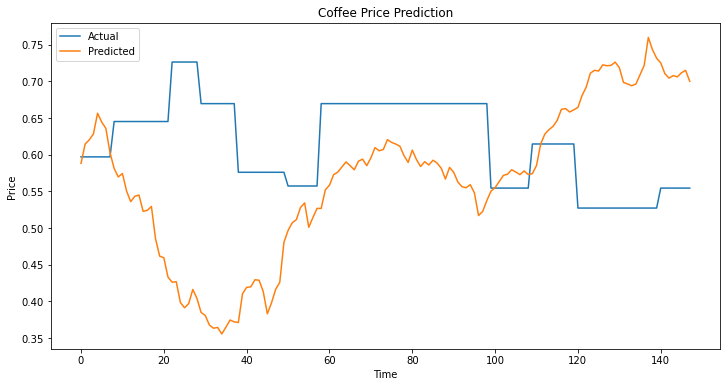

In [43]:
# -----Plot actual vs. predicted prices-------
plt.figure(figsize=(12, 6))
plt.plot(test_y, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("Coffee Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [44]:
# Calculate RMSE (Root Mean Squared Error) to evaluate the model
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print(f"RMSE: {rmse}")

RMSE: 0.15044207499621365


# ---------- Testing & Results Analysis ----------

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Define metrics functions
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    testScore = root_mean_squared_error(test, pre_test)
    print('RMSE: %.2f' % testScore)
    
    testScore = mean_absolute_error(test, pre_test)
    print('MAE: %.2f' % testScore)
    
    testScore = mean_absolute_percentage_error(test, pre_test)
    print('MAPE: %.2f' % testScore)
    
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('MASE: %.2f' % testScore)


In [56]:
test_X.shape

(148, 121)

In [60]:
test_pred = results.predict(start=0, end=len(test_X) - 1, exog=test_X)

In [62]:
test_pred.shape

(148,)

In [63]:
test_X_selected = test_X[:, :3]

In [64]:
# invert scaling for forecast
inv_test_pred = concatenate((test_pred.reshape(-1, 1), test_X_selected), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]

In [65]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [66]:
# print results
print_metrics(inv_y, inv_test_pred)

RMSE: 0.55
MAE: 0.54
MAPE: 0.88
MASE: 113.46


# ---------- Predicting ----------